# EEGMapping: Group Analysis (Local Data)

Words, words, words.

In [1]:
%matplotlib inline
%load_ext autoreload

import os
import pickle
from copy import deepcopy

import mne
import numpy as np
import pandas as pd
from matplotlib import cm
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from scipy.stats import ttest_1samp, ttest_ind, sem, pearsonr

from fooof import FOOOF, FOOOFGroup

In [19]:
# Import custom code for this analysis
% autoreload 2
from plots import *
from utilities import *
from analysis import *

## Settings

Put all general settings here. 

In [3]:
# Set whether to save out all the figures
SAVE_FIGS = True

# Whether to make the data
MASKING = True

# This controls how much stuff MNE prints out
mne.set_log_level(verbose=False)

# To Do's - master version:

### Plotting
- Figure out how to plot topographies with nan values
    - Use MNE masks to select which channels will be plotted
        - Suggestion: add a check for which channels have data. Boolean select these channels & positions to pass into plotting.
- Reorganize notebook for which parts you have to re run

### Quantitative Corrs
- Set it up to measure correlation & plot scatterplot
    - Generally, for any band, any FOOOF feature 
        - First: set band & feature, run to see results (finish the generalization: get a scatter plot & corr)
        - Also: add to plot Medial -> Lateral (abs)
- Collect all R's into corr matrix
- Bonus: plot the corr matrix as a colored plot (red/blue). Hint: plt.imshow(matrix). Extra bonus: add a colorbar. 
        
### Per subject analysis
- Do the same spatial correlations, per subject, collect distributions of r-vals & p-vals
- Plot: boxplots of the R-values, across subjects

### Band to Band Correlations
- Amplitude-amplitude correlations between bands (across channels)
- Plot: corr-matrix

# Loading information

In [4]:
#lOADING CHANNELS FROM txt
save_path = "C:\\Users\\abc\\EEG-MNE\\data"
chan_dat = 'channel_dat.txt'
chan_file = os.path.join(save_path, chan_dat)

In [5]:
subj_dat_num = list(range(3502, 3516))
subj_dat_num2 =list(range(3001, 3015))
all_subj = subj_dat_num + subj_dat_num2

In [6]:
#LOADING CHANNELS from raw data
# This base path will need updating
base_path = 'D:\\abc\\Documents\\Research\\PBA_Data'

# These should stay the same
#subj_dat_fname = '._3001_resampled.set'
subj_dat_fname = '3002_resampled.set'
full_path = os.path.join(base_path, subj_dat_fname)
eeg_dat = mne.io.read_raw_eeglab(full_path, preload=True)

Events like the following will be dropped entirely: ['SPACE pressed', 'Recording_Start', 'Flash_thresh', 'Flash_instr', 'Instructions_End'], 26 in total
5738/6872 event codes could not be mapped to integers. Use the 'event_id' parameter to map such events manually.


<ipython-input-6-a604fe0b632b>:9: RuntimeWarning: Events like the following will be dropped entirely: ['SPACE pressed', 'Recording_Start', 'Flash_thresh', 'Flash_instr', 'Instructions_End'], 26 in total
  eeg_dat = mne.io.read_raw_eeglab(full_path, preload=True)
<ipython-input-6-a604fe0b632b>:9: RuntimeWarning: 5738/6872 event codes could not be mapped to integers. Use the 'event_id' parameter to map such events manually.
  eeg_dat = mne.io.read_raw_eeglab(full_path, preload=True)


In [7]:
# Load and set the montage for the data
montage = mne.channels.read_montage('standard_1020', eeg_dat.ch_names)
eeg_dat.set_montage(montage)

<RawEEGLAB  |  3002_resampled.fdt, n_channels x n_times : 65 x 1896482 (3793.0 sec), ~940.6 MB, data loaded>

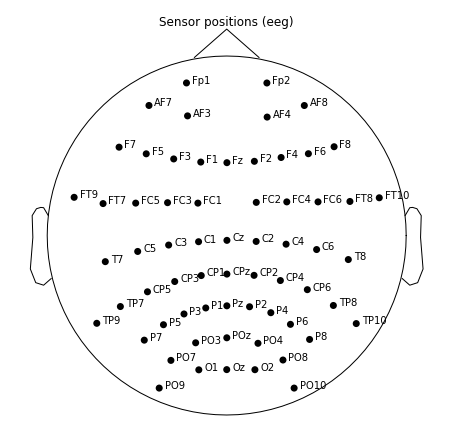

In [8]:
eeg_dat.plot_sensors(show_names=True);

In [9]:
# Extract channel positions from a subjects data object
pos_new = np.asarray([ch['loc'][:3] for ch in eeg_dat.info['chs']])

# Drop stim channel
pos_new = pos_new[:-1, :]

In [10]:
# Update montage with channel positions
montage.pos = pos_new
pos = montage.get_pos2d()
montage = None

# DATA SET UP

In [11]:
# NEW Data
ret = open('..\\data\\analysis\\rtPB_rest_results.pkl','rb')
rtPB_rest_results = pickle.load(ret)

ret = open('..\\data\\analysis\\rtPB_trial_results.pkl','rb')
rtPB_trial_results = pickle.load(ret)

ret = open('..\\data\\analysis\\PBA_rest_results.pkl','rb')
PBA_rest_results = pickle.load(ret)

ret = open('..\\data\\analysis\\PBA_trial_results.pkl','rb')
PBA_trial_results = pickle.load(ret)

In [12]:
# Slope Data
slope_ret = open('..\\data\\analysis\\rtPB_rest_slope_results.pkl','rb')
rtPB_rest_slope_results = pickle.load(slope_ret)

slope_ret = open('..\\data\\analysis\\rtPB_trial_slope_results.pkl','rb')
rtPB_trial_slope_results = pickle.load(slope_ret)

slope_ret = open('..\\data\\analysis\\PBA_rest_slope_results.pkl','rb')
PBA_rest_slope_results = pickle.load(slope_ret)

slope_ret = open('..\\data\\analysis\\PBA_trial_slope_results.pkl','rb')
PBA_trial_slope_results = pickle.load(slope_ret)

# Masking
## This would allow you to choose an entire region to look over

In [13]:
# Set the channel cluster of interest    
pos_ch_cluster = ['Oz','O1','O2','POz','PO3','PO4','PO7','PO8','PO9','PO10']
# Check the indices for the channel cluster
pos_ch_cluster_index = masking_cluster(pos_ch_cluster,eeg_dat)

In [14]:
# dataset
curr_data = "Combined"

if (curr_data=="PBA"):
    curr_datasets = [PBA_trial_results, PBA_rest_results]
elif (curr_data=="rtPB"):
    curr_datasets = [rtPB_trial_results, rtPB_rest_results]
elif (curr_data=="Combined"):
    comb_rest = combine_groups(rtPB_rest_results, PBA_rest_results)
    comb_trial = combine_groups(rtPB_trial_results, PBA_trial_results)
    curr_datasets = [comb_trial, comb_rest]
else:
    print("The dataset you have specified does not exist")

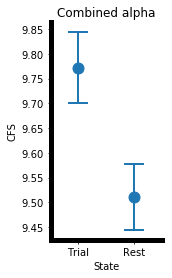

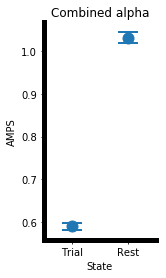

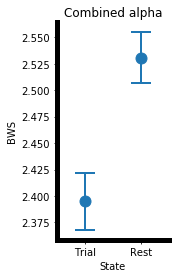

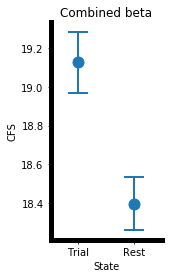

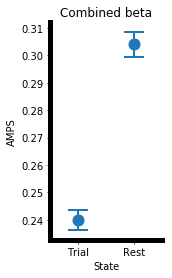

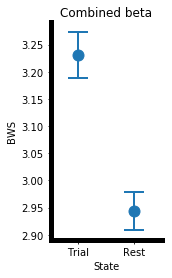

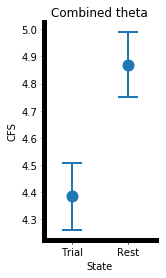

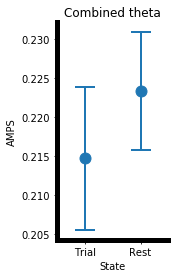

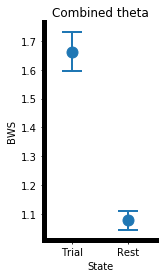

In [15]:
bands = ["alpha", "beta", "theta"]
feats = ["CFS", "AMPS", "BWS"]

for band in bands:
    for feat_in, feat in enumerate(feats):
        outputs = []
        for dataset in curr_datasets:
            #masked_data = np.take(dataset[band], indices=pos_ch_cluster_index,  axis=2 )
            masked_data = dataset[band]
            if (curr_data == "Combined"):
                masked_feat_in = masked_data[:,:,feat_in]
                outputs.append(masked_feat_in)
            else:
                masked_feat_in = masked_data[:,:,:,feat_in]
                masked_feat_in_first = masked_feat_in[:,0,:]
                outputs.append(masked_feat_in_first)
        title = curr_data + " " + band
        feature = feat
        plot_comp(title, feature, outputs[0],outputs[1], save_fig=SAVE_FIGS)
        save_figure(SAVE_FIGS, title +"_" + feature + "_across_state")

# Across STATE slope plots

In [16]:
# dataset
curr_data = "Combined"

if (curr_data=="PBA"):
    curr_datasets = [PBA_trial_slope_results, PBA_rest_slope_results]
elif (curr_data=="rtPB"):
    curr_datasets = [rtPB_trial_slope_results, rtPB_rest_slope_results]
elif (curr_data=="Combined"):
    slope_comb_rest = combine_slope_groups(rtPB_rest_slope_results, PBA_rest_slope_results)
    slope_comb_trial = combine_slope_groups(rtPB_trial_slope_results, PBA_trial_slope_results)
    curr_datasets = [slope_comb_trial, slope_comb_rest]
else:
    print("The dataset you have specified does not exist")

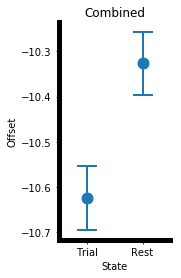

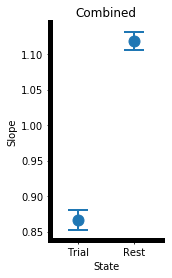

In [17]:
feats = ["Offset", "Slope"]

for feat_in, feat in enumerate(feats):
    outputs = []
    for dataset in curr_datasets:
        #masked_data = np.take(dataset, indices=pos_ch_cluster_index,  axis=2 )
        masked_data = dataset
        if (curr_data == "Combined"):
            masked_feat_in = masked_data[:,:,feat_in]
            outputs.append(masked_feat_in)
        else:
            masked_feat_in = masked_data[:,:,:,feat_in]
            masked_feat_in_first = masked_feat_in[:,0,:]
            outputs.append(masked_feat_in_first)
    title = curr_data 
    feature = feat
    plot_comp(title, feature, outputs[0],outputs[1], save_fig=SAVE_FIGS)
    save_figure(SAVE_FIGS, title +"_" + feature + "_across_state")

# Comparrison across blocks

C:\Users\abc\Documents\Research\EEGMapping\local\notebooks\analysis.py:99: RuntimeWarning: Mean of empty slice
  demeaned_curr_mean_data = np.nanmean(demeaned_curr_masked_data, axis=2)
C:\Users\abc\Documents\Research\EEGMapping\local\notebooks\analysis.py:99: RuntimeWarning: Mean of empty slice
  demeaned_curr_mean_data = np.nanmean(demeaned_curr_masked_data, axis=2)
C:\Users\abc\Documents\Research\EEGMapping\local\notebooks\analysis.py:99: RuntimeWarning: Mean of empty slice
  demeaned_curr_mean_data = np.nanmean(demeaned_curr_masked_data, axis=2)
C:\Users\abc\Documents\Research\EEGMapping\local\notebooks\analysis.py:99: RuntimeWarning: Mean of empty slice
  demeaned_curr_mean_data = np.nanmean(demeaned_curr_masked_data, axis=2)
C:\Users\abc\Documents\Research\EEGMapping\local\notebooks\analysis.py:99: RuntimeWarning: Mean of empty slice
  demeaned_curr_mean_data = np.nanmean(demeaned_curr_masked_data, axis=2)
C:\Users\abc\Documents\Research\EEGMapping\local\notebooks\analysis.py:99: 

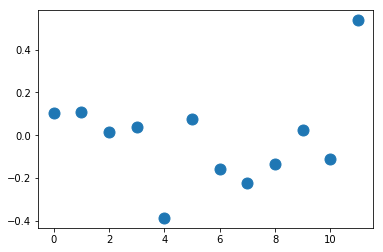

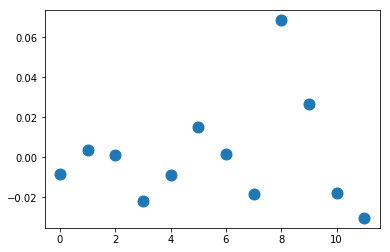

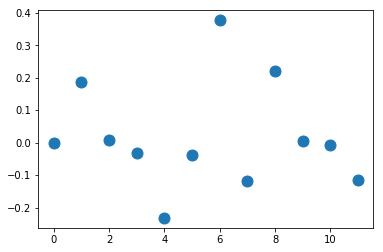

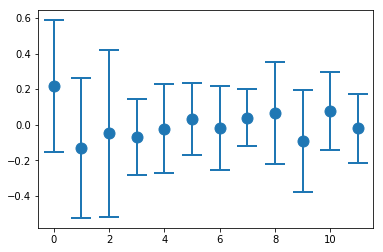

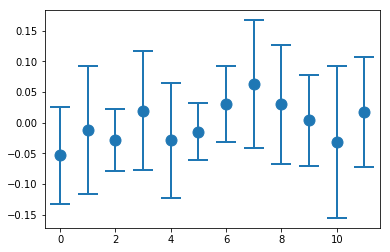

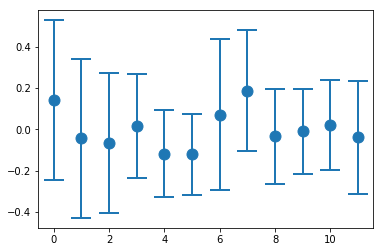

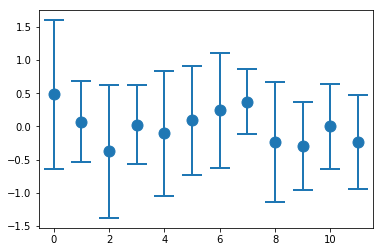

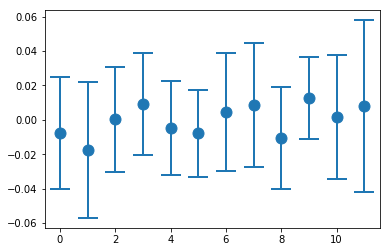

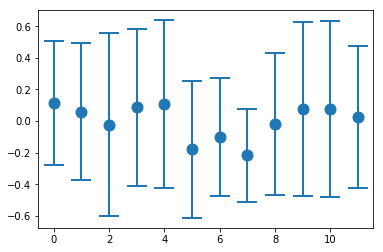

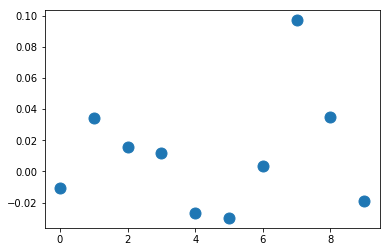

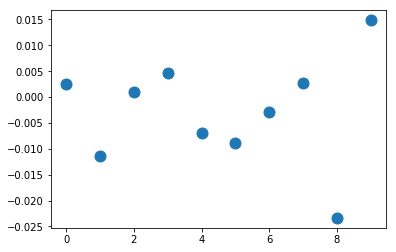

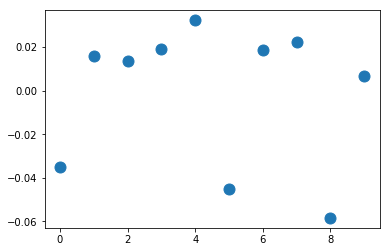

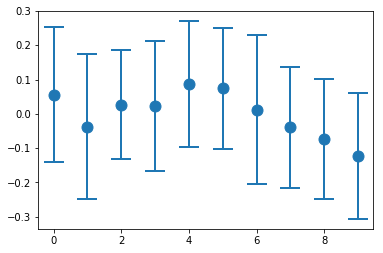

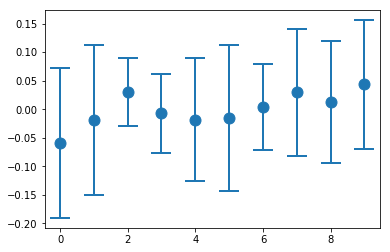

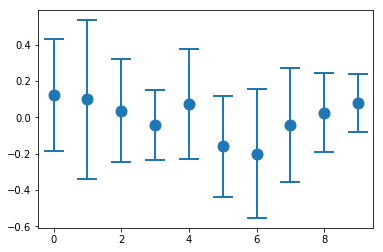

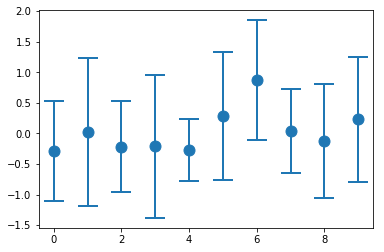

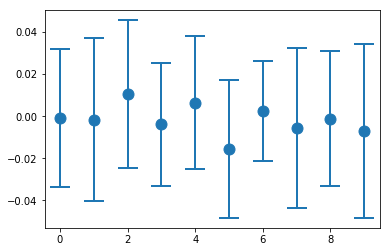

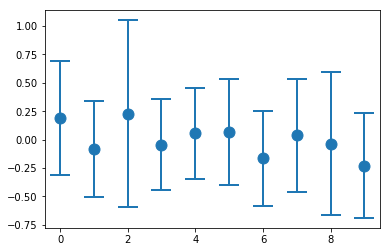

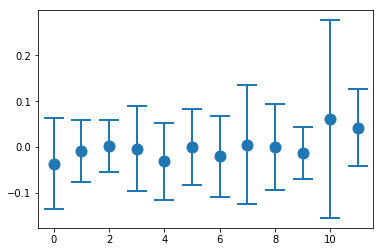

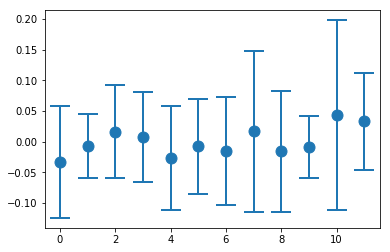

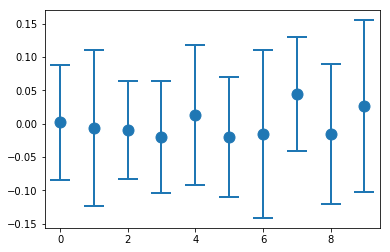

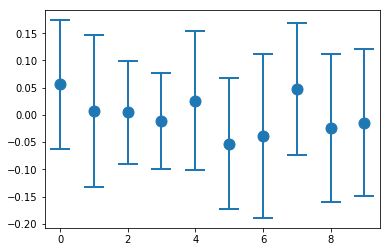

In [20]:
PBA_across_corr_trial = run_dict_across_blocks('PBA', PBA_trial_results, pos_ch_cluster_index, True)
rtPB_across_corr_trial = run_dict_across_blocks('rtPB', rtPB_trial_results, pos_ch_cluster_index, True)


PBA_across_slope_corr_trial = run_array_across_blocks('PBA', PBA_trial_slope_results, pos_ch_cluster_index, ['Off', 'Sl'], True)
rtPB_across_slope_corr_trial = run_array_across_blocks('rtPB', rtPB_trial_slope_results, pos_ch_cluster_index, ['Off', 'Sl'], True)

# TOPOPLOTS and SLOPE TOPOPLOTS

C:\Users\abc\Documents\Research\EEGMapping\local\notebooks\utilities.py:37: RuntimeWarning: Mean of empty slice
  bloc_aver_set = np.nanmean(feat_set, axis = 1)


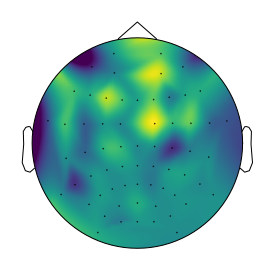

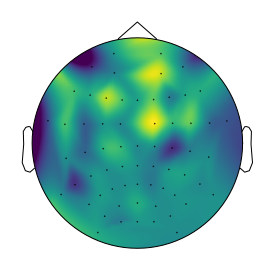

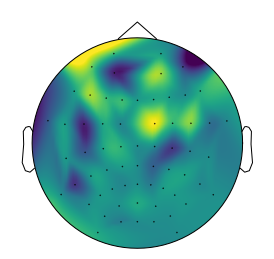

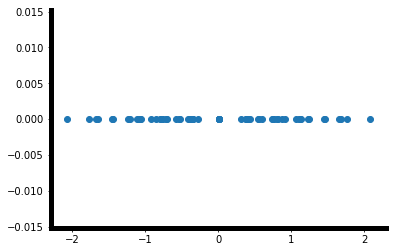

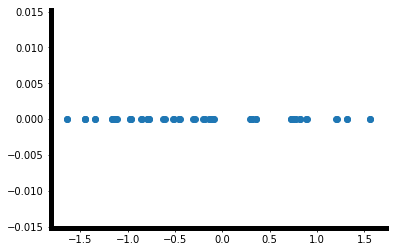

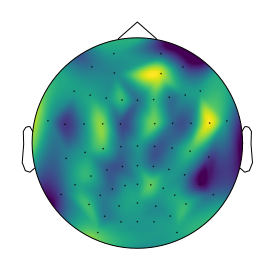

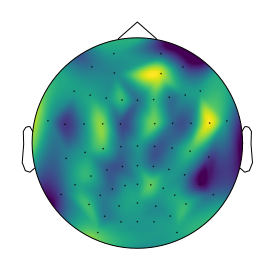

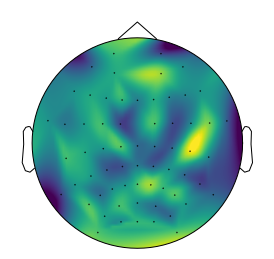

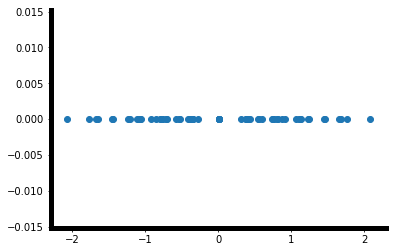

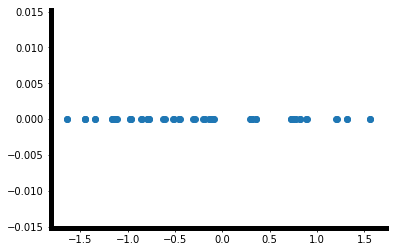

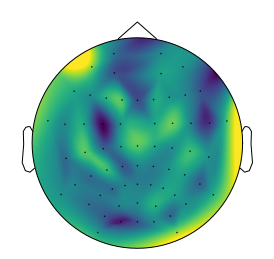

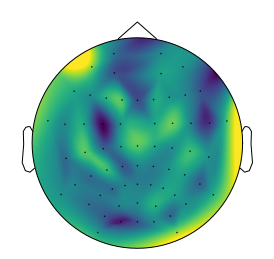

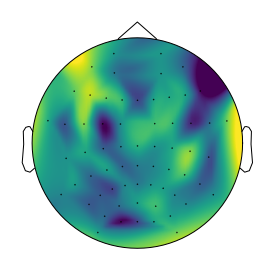

C:\Users\abc\Documents\Research\EEGMapping\local\notebooks\utilities.py:38: RuntimeWarning: Mean of empty slice
  bloc_aver_set = np.nanmean(bloc_aver_set, axis = 0)


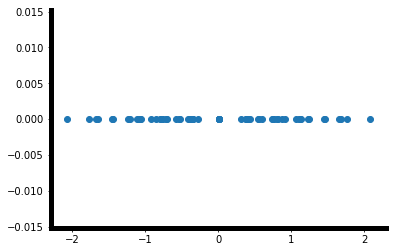

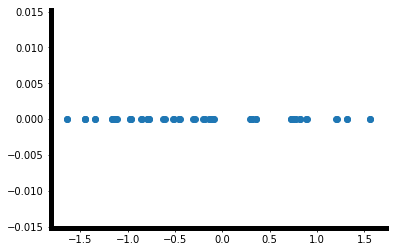

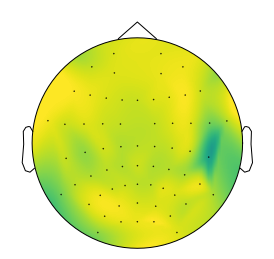

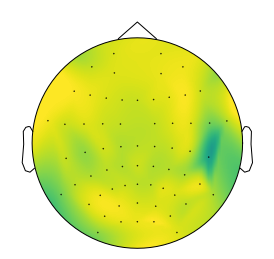

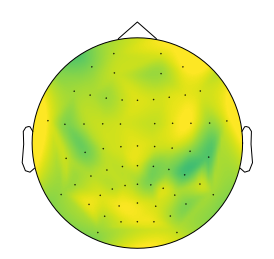

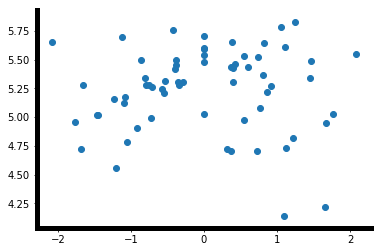

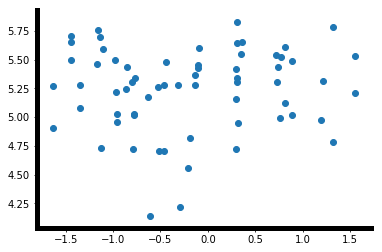

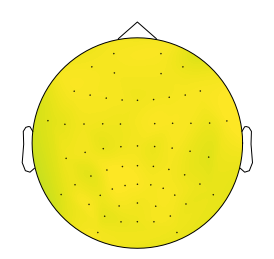

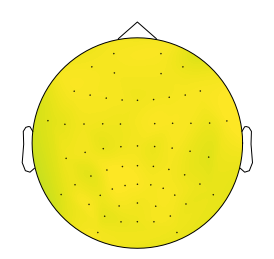

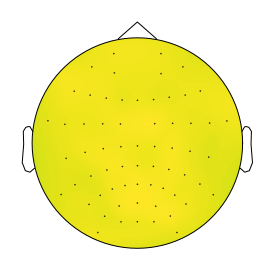

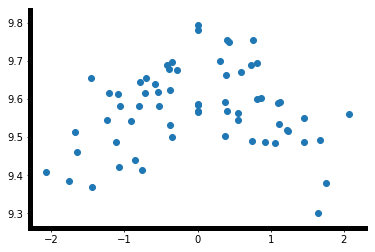

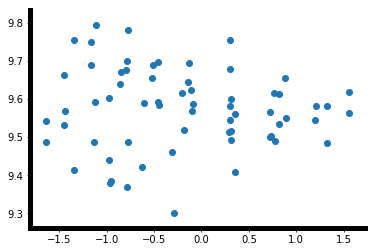

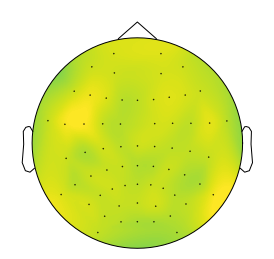

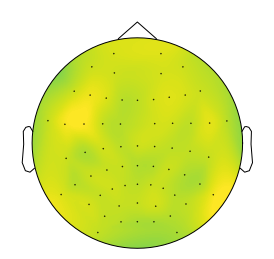

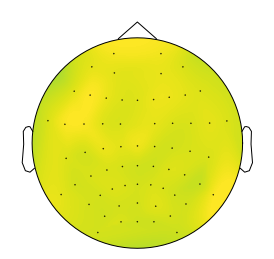

TypeError: make_topos_array() missing 1 required positional argument: 'feats'

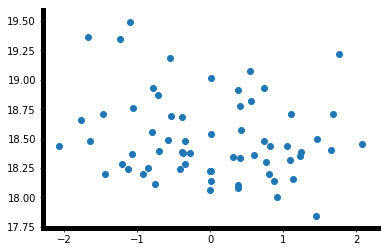

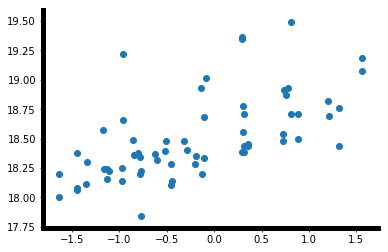

In [21]:
# Make topos, for each state, within and between datasets, for all features and bands

spatial_corr_trial = make_topos_dict([PBA_trial_results, rtPB_trial_results], label= "Trial", eeg_dat_info=eeg_dat.info, pos=pos)
spatial_corr_rest = make_topos_dict([PBA_rest_results, rtPB_rest_results],label = "Rest", eeg_dat_info=eeg_dat.info, pos=pos)
spatial_slope_corr_trial = make_topos_array([PBA_trial_slope_results, rtPB_trial_slope_results], label = "Trial", eeg_dat_info=eeg_dat.info, pos=pos)
spatial_slope_corr_trial = make_topos_array([PBA_trial_slope_results, rtPB_trial_slope_results], label = "Trial", eeg_dat_info=eeg_dat.info, pos=pos)

# Spatial Correlations Between Bands

In [ ]:
index = group_bands.keys()
d_corrm = pd.DataFrame(index=index, columns=index, dtype = float)
#Dataframe for correlaton matrix
for band in group_bands:
    data1 = group_bands[band][:,features[feature]]
    for band2 in group_bands:
        data2 = group_bands[band2][:,features[feature]]
        masked_arr1=mask_nan_array(data1)
        masked_arr2=mask_nan_array(data2)
        corr_val = pearsonr(data1, data2)[0]
        d_corrm.loc[band, band2] = corr_val


In [ ]:
d_corrm

In [ ]:
pearsonr?

In [ ]:
d_corrm.values

In [ ]:
np.mean(topo_dat, 0).shape

In [ ]:
plt.imshow(d_corrm)